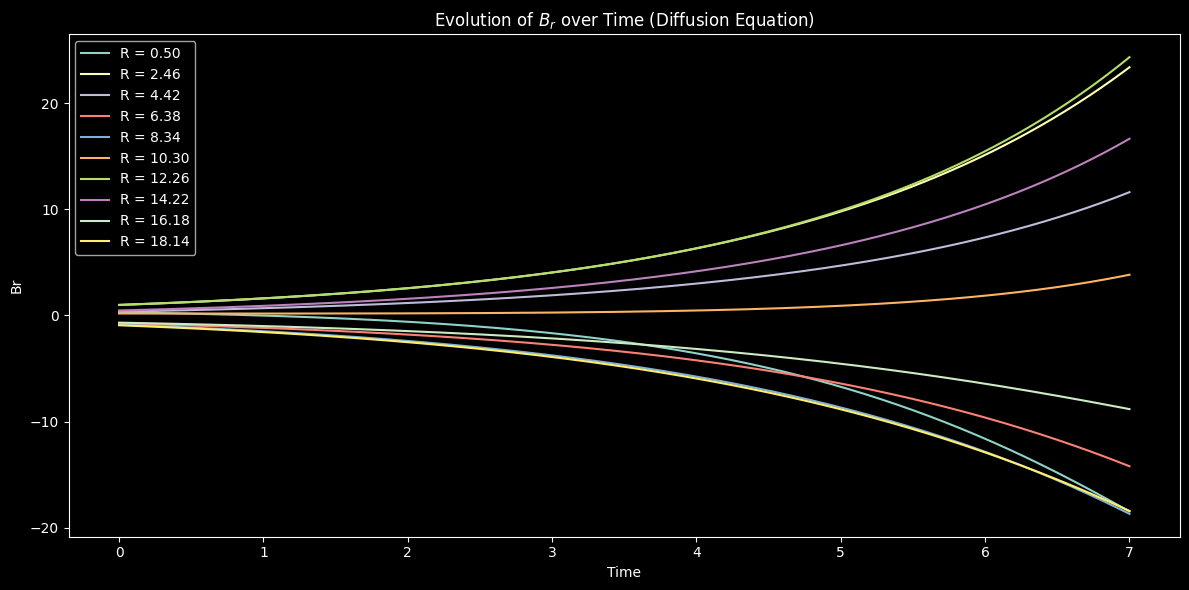

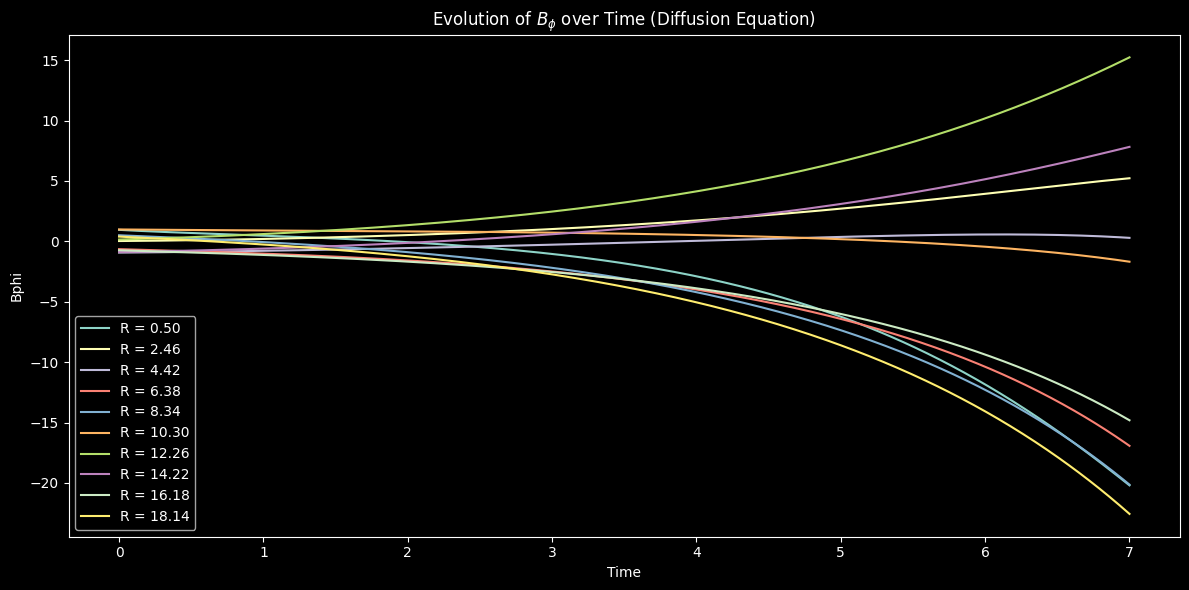

array([-0.5724334 , -0.72340891, -0.85708168, -0.96899491, -1.05810543,
       -1.12558508, -1.17380562, -1.20561382, -1.22387787, -1.23123999,
       -1.23000666, -1.22212162, -1.20918371, -1.19248538, -1.17305792,
       -1.15171593, -1.12909737, -1.1056981 , -1.08190062, -1.05799759,
       -1.03421082, -1.01070646, -0.98760708, -0.96500117, -0.94295078,
       -0.92149734, -0.90066643, -0.88047138, -0.86091622, -0.84199788,
       -0.823708  , -0.8060343 , -0.7889617 , -0.77247313, -0.75655019,
       -0.74117371, -0.72632408, -0.71198159, -0.69812667, -0.68474001,
       -0.67180275, -0.65929652, -0.64720354, -0.63550665, -0.62418932,
       -0.61323568, -0.60263052, -0.59235928, -0.58240805, -0.57276353,
       -0.56341303, -0.55434446, -0.54554627, -0.53700747, -0.52871759,
       -0.52066664, -0.51284511, -0.50524394, -0.4978545 , -0.49066857,
       -0.48367831, -0.47687625, -0.47025527, -0.46380858, -0.45752969,
       -0.45141244, -0.44545092, -0.4396395 , -0.43397282, -0.42

In [79]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
eta_diffusivity = 0.25  # turbulent magnetic diffusivity
np.random.seed(42)

# Radial grid
R_max = 20  # Maximum radial distance (in kpc)
Nr = 200  # Increased number of grid points in radial direction
dr = R_max / Nr

# Time parameters
Total_Time= 7  # Increased total time
Nt = 500  # Increased number of time steps
dt = Total_Time/ Nt
h = 1

# Initial magnetic field (considering only the radial component)
R = np.linspace(0.5, R_max, Nr)
Br = np.sin((4 * np.pi * R) / R_max)
Bphi = np.cos(4 * np.pi * R / R_max)

# Function to compute the radial Laplacian of Br
alpha_0 = 0.2
def compute_laplacian_Br(R, Br, Bphi):
    return eta_diffusivity * (np.gradient((1 / R) * np.gradient(R * Br, dr), dr) + ((np.pi) ** 2) * Br / (4 * h ** 2)) \
           - (2 * alpha_0 * Bphi / np.pi)

# Function to compute the radial Laplacian of Bphi
omega0 = 1
r_omega = 1
def compute_laplacian_Bphi(R, Br, Bphi):
    Omega = omega0 / (1 + (R / r_omega) ** 2) ** 0.5
    q = ((R / r_omega) ** 2) * (1 + (R / r_omega) ** 2) ** (-1)

    return eta_diffusivity * (np.gradient((1 / R) * np.gradient(R * Bphi, dr), dr) + ((np.pi) ** 2) * Br / (4 * h ** 2)) \
           - (q * Omega * Br)
           


# Runge-Kutta method for solving the diffusion equation
def runge_kutta_step(R, Br, Bphi, dt):
    k1_Br = dt * compute_laplacian_Br(R, Br, Bphi)
    k1_Bphi = dt * compute_laplacian_Bphi(R, Br, Bphi)[0]

    k2_Br = dt * compute_laplacian_Br(R + 0.5 * k1_Br, Br + 0.5 * k1_Br, Bphi + 0.5 * k1_Br)
    k2_Bphi = dt * compute_laplacian_Bphi(R + 0.5 * k1_Bphi, Br + 0.5 * k1_Bphi, Bphi + 0.5 * k1_Bphi)

    k3_Br = dt * compute_laplacian_Br(R + 0.5 * k2_Br, Br + 0.5 * k2_Br, Bphi + 0.5 * k2_Br)
    k3_Bphi = dt * compute_laplacian_Bphi(R + 0.5 * k2_Bphi, Br + 0.5 * k2_Bphi, Bphi + 0.5 * k2_Bphi)

    k4_Br = dt * compute_laplacian_Br(R + k3_Br, Br + k3_Br, Bphi + k3_Br)
    k4_Bphi = dt * compute_laplacian_Bphi(R + k3_Bphi, Br + k3_Bphi, Bphi + k3_Bphi)

    new_Br = Br + (k1_Br + 2 * k2_Br + 2 * k3_Br + k4_Br) / 6
    new_Bphi = Bphi + (k1_Bphi + 2 * k2_Bphi + 2 * k3_Bphi + k4_Bphi) / 6

    return new_Br, new_Bphi

# Store the evolution of magnetic field at different radial positions
evolution_of_Br = np.zeros((Nt + 1, Nr))
evolution_of_Bphi = np.zeros((Nt + 1, Nr))

# Time-stepping scheme using Runge-Kutta
for t in range(Nt + 1):
    D = []
    evolution_of_Br[t, :] = np.copy(Br)
    evolution_of_Bphi[t, :] = np.copy(Bphi)
    Br, Bphi = runge_kutta_step(R, Br, Bphi, dt)
    Omega = omega0 / (1 + (R / r_omega) ** 2) ** 0.5
    q = ((R / r_omega) ** 2) * (1 + (R / r_omega) ** 2) ** (-1)
    D_ = -(alpha_0*q*Omega*h**3)/(eta_diffusivity**2)
    D.append(D_)

# Plot the magnetic field components Br and Bphi with time at different radial positions
plt.figure(figsize=(12, 6))
for i in range(0, Nr, Nr // 10):
    #D = compute_D(alpha_0, Omega, )
    # Plot every 10th radial position
    plt.plot(np.linspace(0, Total_Time, Nt + 1), evolution_of_Br[:, i], label=f'R = {R[i]:.2f}')
plt.xlabel('Time')
plt.ylabel('Br')
plt.title('Evolution of $B_r$ over Time (Diffusion Equation)')
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))
for i in range(0, Nr, Nr // 10):  # Plot every 10th radial position
    plt.plot(np.linspace(0, Total_Time, Nt + 1), evolution_of_Bphi[:, i], label=f'R = {R[i]:.2f}')
plt.xlabel('Time')
plt.ylabel('Bphi')
plt.title('Evolution of $B_\phi$ over Time (Diffusion Equation)')
plt.legend()
plt.tight_layout()
plt.show()

D[0]


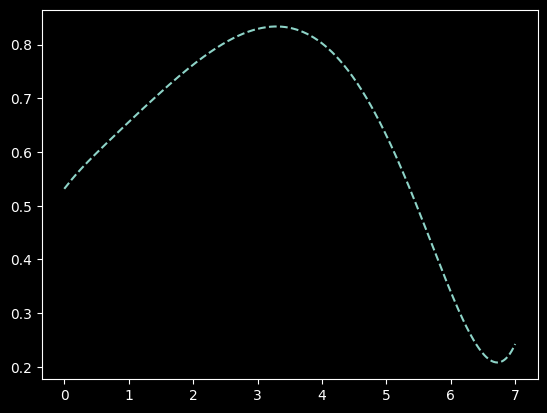

In [74]:
Time = np.linspace(0, Total_Time, Nt + 1)
B_magnitude = evolution_of_Br[:,4]  # Magnitude at a specific radial position
plt.plot(Time, B_magnitude, label='Magnetic Magnitude (|Br|)', linestyle='--')

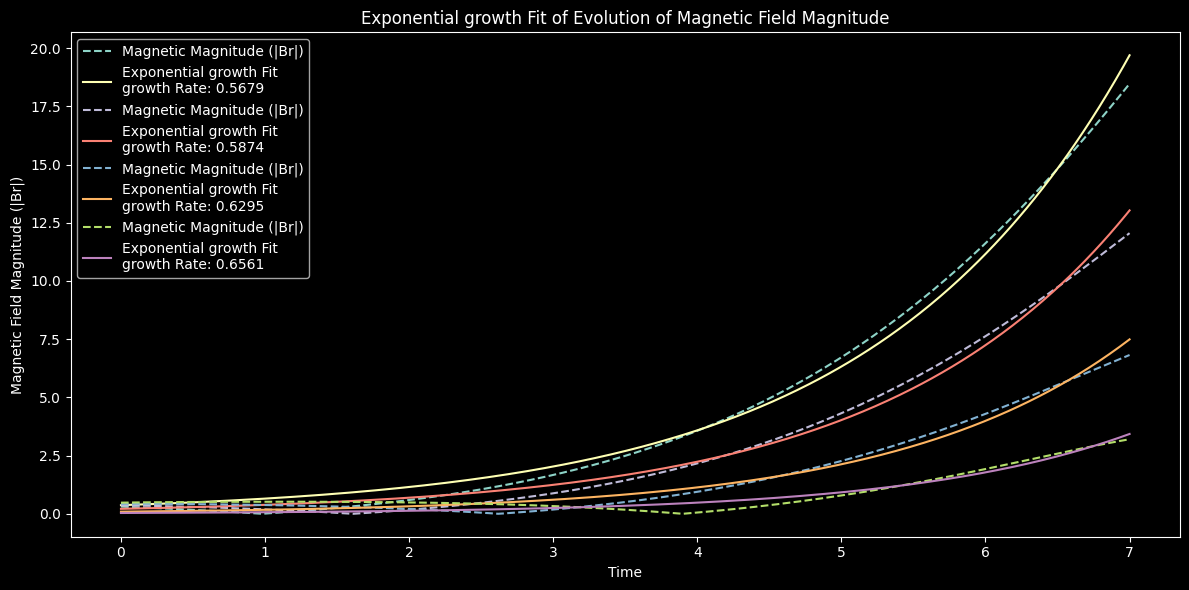

In [71]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit


# Define a function for exponential decay
def Expo_growth_func(t, amplitude, growth_rate):
    return amplitude * np.exp(growth_rate * t)

# Extract time and magnetic field magnitude data
Time = np.linspace(0, Total_Time, Nt + 1)

# Plotting the fit
plt.figure(figsize=(12, 6))
for i in range(4):
    B_magnitude = np.abs(evolution_of_Br[:, i])  # Magnitude at a specific radial position
    plt.plot(Time, B_magnitude, label='Magnetic Magnitude (|Br|)', linestyle='--')
    # Fit the data to the exponential growth model
    fit_params, _ = curve_fit(Expo_growth_func, Time, B_magnitude)
    plt.plot(Time, Expo_growth_func(Time, *fit_params),  label=f'Exponential growth Fit\ngrowth Rate: {fit_params[1]:.4f}')
plt.xlabel('Time')
plt.ylabel('Magnetic Field Magnitude (|Br|)')
plt.title('Exponential growth Fit of Evolution of Magnetic Field Magnitude')
plt.legend()
plt.tight_layout()
plt.show()


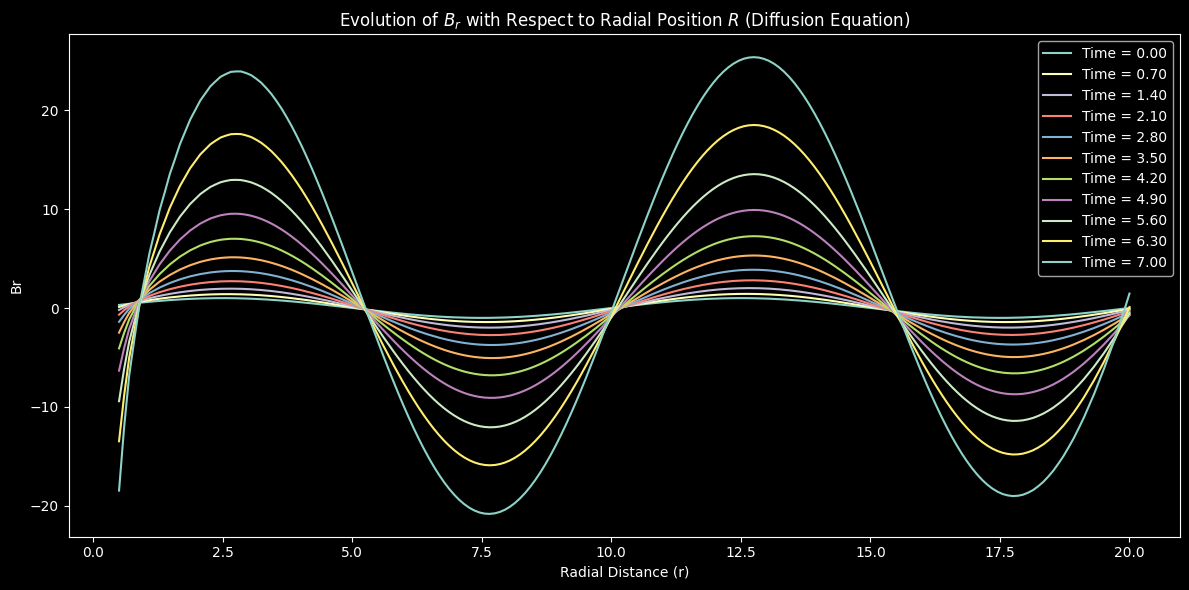

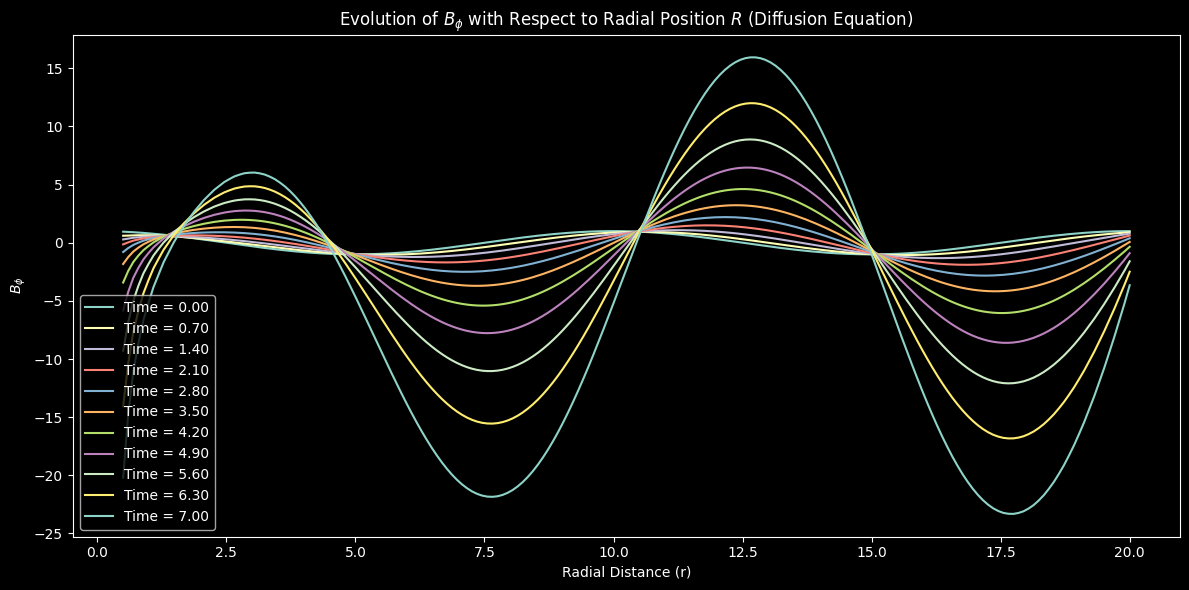

In [63]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
eta_diffusivity = 0.25  # turbulent magnetic diffusivity
np.random.seed(42)

# Radial grid
R_max = 20  # Maximum radial distance (in kpc)
N_grid = 200  # Increased number of grid points in radial direction
R = np.linspace(0.5, R_max, N_grid)
dr = R_max / N_grid

# Time parameters
Total_Time = 7  # Increased total time
N_t = 500  # Increased number of time steps
dt = Total_Time / N_t

# Initialize magnetic field B (considering both radial and azimuthal components)
Br = np.sin(4 * np.pi * R / R_max)
Bphi = np.cos(4 * np.pi * R / R_max)   # Initialize azimuthal component as zero




# Store the evolution of magnetic field components at different radial positions
evolution_r = np.zeros((N_t + 1, N_grid))


# Time-stepping scheme using Runge-Kutta
for t in range(N_t + 1):
    evolution_r[t, :] = np.copy(Br[0])  # Extracting new_Br from the tuple
    Br, Bphi = runge_kutta_step(R, Br, Bphi, dt)  # Update Br and Bphi


# Plot for Br
plt.figure(figsize=(12, 6))
for t in range(0, N_t + 1, N_t // 10):  # Plot every 10th time step
    plt.plot(R, evolution_of_Br[t, :], label=f'Time = {t * dt:.2f}')
plt.xlabel('Radial Distance (r)')
plt.ylabel('Br')
plt.title('Evolution of $B_r$ with Respect to Radial Position $R$ (Diffusion Equation)')
plt.legend()
plt.tight_layout()
plt.show()

# Plot for Bphi
plt.figure(figsize=(12, 6))
for t in range(0, N_t + 1, N_t // 10):  # Plot every 10th time step
    plt.plot(R, evolution_of_Bphi[t, :], label=f'Time = {t * dt:.2f}')
plt.xlabel('Radial Distance (r)')
plt.ylabel('$B_{\phi}$')
plt.title('Evolution of $B_{\phi}$ with Respect to Radial Position $R$ (Diffusion Equation)')
plt.legend()
plt.tight_layout()
plt.show()


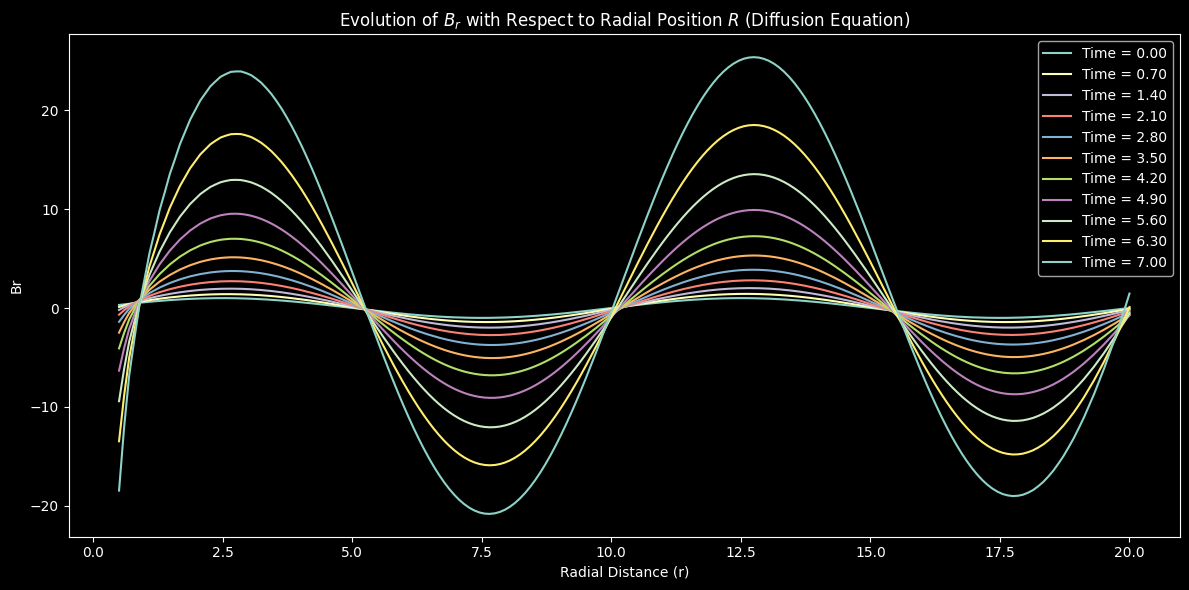

MovieWriter imagemagick unavailable; using Pillow instead.


<Figure size 640x480 with 0 Axes>

In [64]:
from matplotlib.animation import FuncAnimation
frames=[]

plt.figure(figsize=(12, 6))
for t in range(0, N_t + 1, N_t // 10):  # Plot every 10th time step
    fig = plt.plot(R, evolution_of_Br[t, :], label=f'Time = {t * dt:.2f}')
plt.xlabel('Radial Distance (r)')
plt.ylabel('Br')
plt.title('Evolution of $B_r$ with Respect to Radial Position $R$ (Diffusion Equation)')
plt.legend()
plt.tight_layout()
frames.append(fig)
plt.show()

# Create GIF animation
animation = FuncAnimation(plt.gcf(), lambda x: None, frames=frames, interval=500)
animation.save('evolution_of_Br.gif', writer='imagemagick')
plt.show()